In [9]:
import pandas as pd
import numpy as np
from tslearn.utils import to_time_series_dataset
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, TimeSeriesResampler
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
import os
filepath = os.getcwd()


In [10]:

def perform_elbow_analysis(file_path, max_clusters=10, sep=';'):
    data = pd.read_csv(file_path, index_col=0, sep=sep)
    data_reset = data.reset_index()
    long_df = data_reset.melt(id_vars=['Id'], var_name='Time', value_name='Value')
    long_df.sort_values(by=['Id', 'Time'], inplace=True)

    grouped = long_df.groupby('Id')['Value'].apply(list)
    max_length = grouped.apply(len).max()
    uniform_series = grouped.apply(lambda x: x + [np.nan] * (max_length - len(x)))

    ts_data = to_time_series_dataset(list(uniform_series))
    scaler = TimeSeriesScalerMeanVariance(mu=0., std=1.)
    ts_scaled = scaler.fit_transform(ts_data)

    inertia = []
    for k in range(1, max_clusters + 1):
        model = TimeSeriesKMeans(n_clusters=k, metric="euclidean", verbose=False)
        model.fit(ts_scaled)
        inertia.append(model.inertia_)

    plt.figure(figsize=(8, 5))
    plt.plot(range(1, max_clusters + 1), inertia, marker='o')
    plt.title('Elbow Method for Determining Optimal Clusters')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.grid(True)
    plt.show()


def fit_model_and_visualize_clusters(file_path, n_clusters, sep=';'):
    # Load and preprocess data
    data = pd.read_csv(file_path, index_col=0, sep=sep)
    data_reset = data.reset_index()
    long_df = data_reset.melt(id_vars=['Id'], var_name='Time', value_name='Value')
    long_df.sort_values(by=['Id', 'Time'], inplace=True)

    grouped = long_df.groupby('Id')['Value'].apply(list)
    max_length = grouped.apply(len).max()
    uniform_series = grouped.apply(lambda x: x + [np.nan] * (max_length - len(x)))

    ts_data = to_time_series_dataset(list(uniform_series))
    scaler = TimeSeriesScalerMeanVariance(mu=0., std=1.)
    ts_scaled = scaler.fit_transform(ts_data)

    # Fit the model
    model = TimeSeriesKMeans(n_clusters=n_clusters, metric="euclidean", verbose=True)
    y_pred = model.fit_predict(ts_scaled)

    # Visualize clusters
    plt.figure(figsize=(12, 8))
    for yi in range(n_clusters):
        plt.subplot(n_clusters, 1, yi + 1)
        for xx in ts_scaled[y_pred == yi]:
            plt.plot(xx.ravel(), "k-", alpha=0.2)
        plt.plot(model.cluster_centers_[yi].ravel(), "r-")
        plt.title(f"Cluster {yi + 1}")
        plt.xlim([0, max_length])
    plt.tight_layout()
    plt.show()

    return model, scaler



def predict_cluster(file_path, Id, model, scaler, sep=';'):
    """
    Predicts the cluster for a specified series by its ID from a CSV file and computes the silhouette score.

    Parameters:
    - file_path: str, path to the CSV file containing the time series data.
    - Id: int or str, the index or ID of the series to be predicted.
    - model: fitted TimeSeriesKMeans model.
    - scaler: fitted TimeSeriesScalerMeanVariance.
    - sep: str, delimiter used in the CSV data.

    Returns:
    - pred_cluster: the predicted cluster index.
    - silhouette: silhouette score indicating how well the new data fits into its cluster.
    """

    # Load the data and extract the specific row
    data = pd.read_csv(file_path, index_col=0, sep=sep)
    new_series = data.loc[Id].values  # Extract the row for the given Id

    # Prepare the time series data
    ts_data = to_time_series_dataset([new_series])
    ts_scaled = scaler.transform(ts_data)

    # Predict the cluster
    pred_cluster = model.predict(ts_scaled)

    # Calculate the silhouette score
    if len(model.labels_) > 1:  # Silhouette score cannot be calculated with less than 2 labels
        silhouette = silhouette_score(ts_scaled, model.labels_)
    else:
        silhouette = -1  # Not enough labels to compute silhouette score

    return pred_cluster[0], silhouette


Elbow analysis for 1 year of consumption data


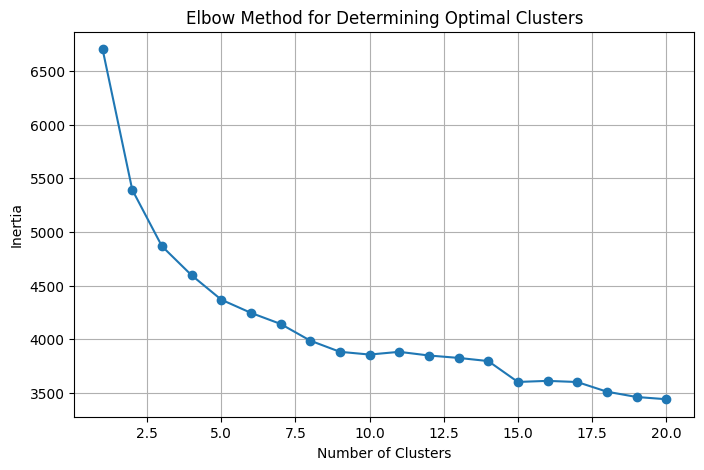

Elbow analysis for 3 years of consumption data


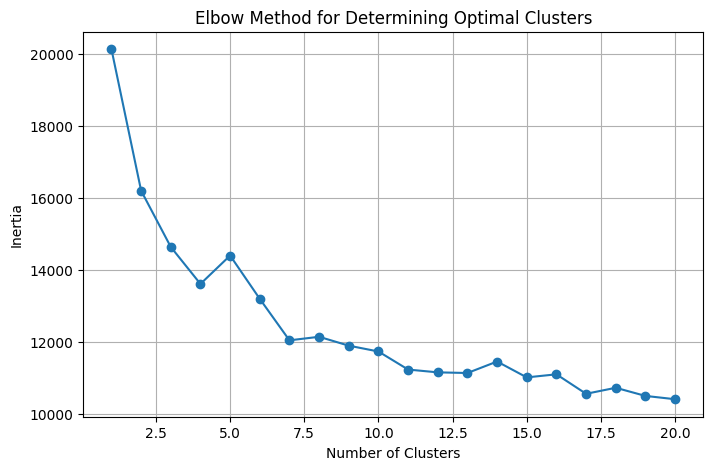

Elbow analysis for 1 year of production data


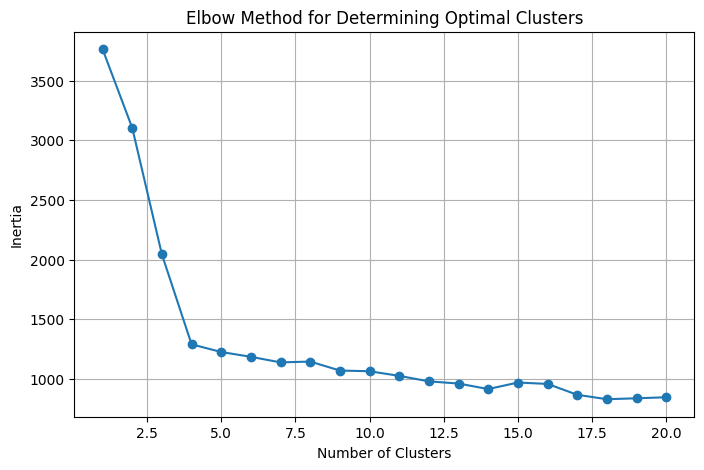

Elbow analysis for 3 years of production data


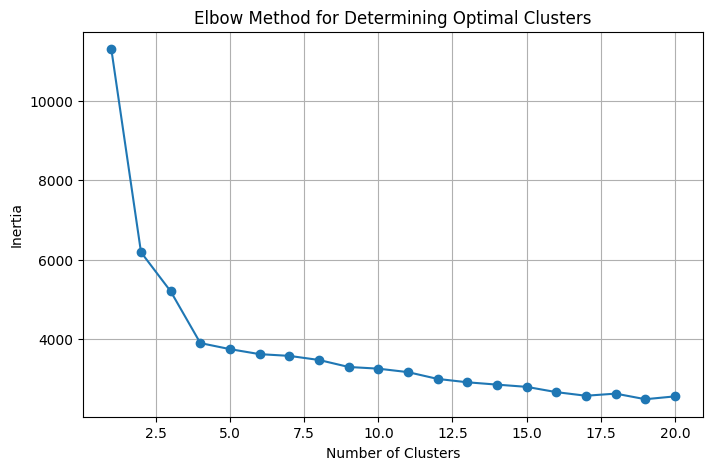

In [12]:
# Determine optimal clusters
consumption1y = filepath+"/dataset/consumption-1y-processed.csv"
print("Elbow analysis for 1 year of consumption data")
perform_elbow_analysis(consumption1y, max_clusters=20)

consumption3y = filepath+"/dataset/consumption-3y-processed.csv"
print("Elbow analysis for 3 years of consumption data")
perform_elbow_analysis(consumption3y, max_clusters=20)

production1y = filepath+"/dataset/production-1y-processed.csv"
print("Elbow analysis for 1 year of production data")
perform_elbow_analysis(production1y, max_clusters=20)

production3y = filepath+"/dataset/production-3y-processed.csv"
print("Elbow analysis for 3 years of production data")
perform_elbow_analysis(production3y, max_clusters=20)




4909.378 --> 4024.721 --> 3926.710 --> 3904.006 --> 3898.923 --> 3892.521 --> 3890.202 --> 3890.202 --> 


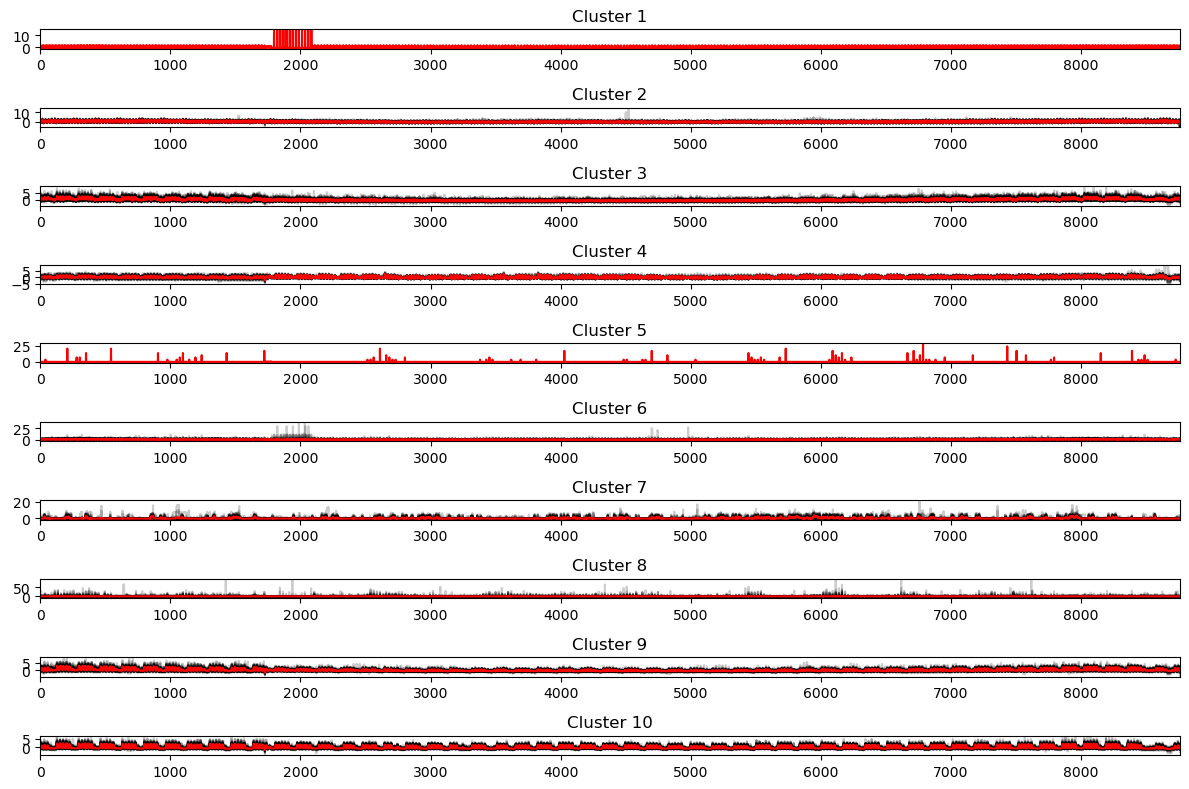

22204.229 --> 11720.340 --> 11514.297 --> 11452.478 --> 11396.350 --> 11366.105 --> 11354.165 --> 11342.795 --> 11328.787 --> 11320.381 --> 11317.796 --> 11317.796 --> 


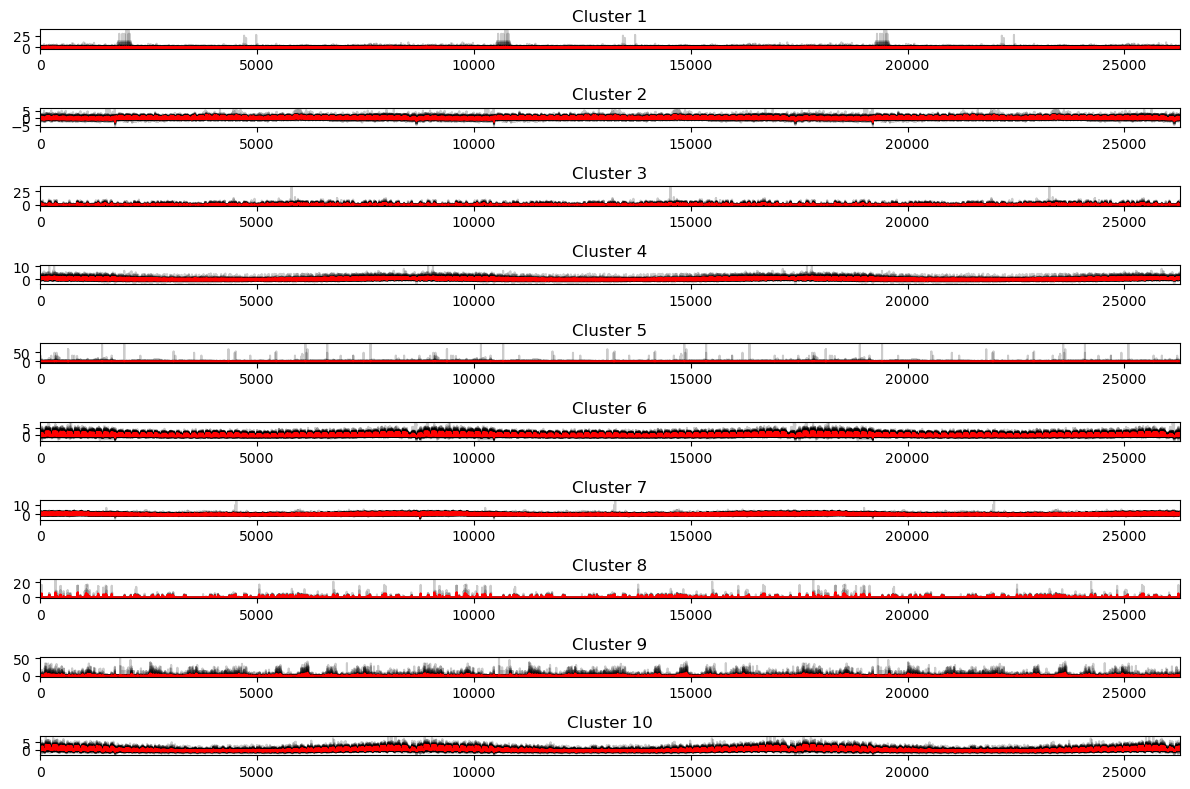

5478.871 --> 4046.896 --> 3928.734 --> 3842.050 --> 3826.249 --> 3819.833 --> 3813.389 --> 3810.148 --> 3810.148 --> 


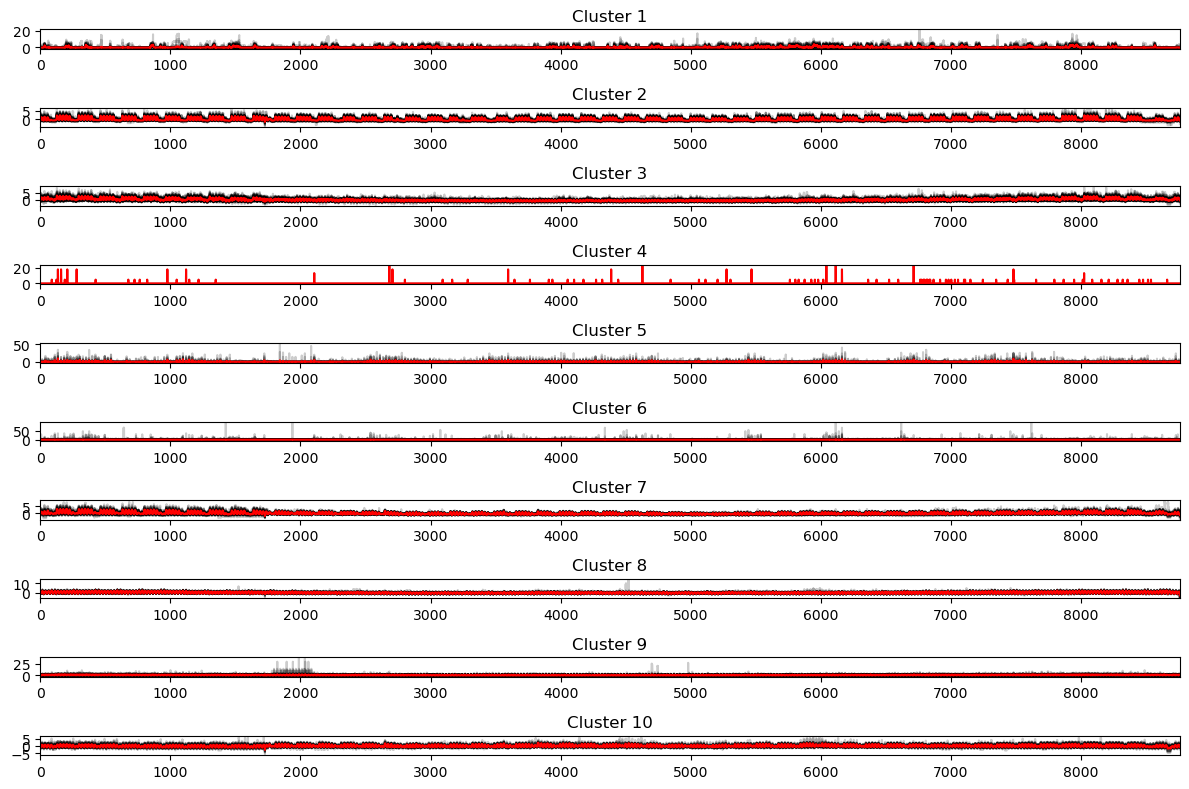

4292.567 --> 3307.620 --> 3270.749 --> 3257.612 --> 3250.551 --> 3240.466 --> 3236.759 --> 3235.598 --> 3235.598 --> 


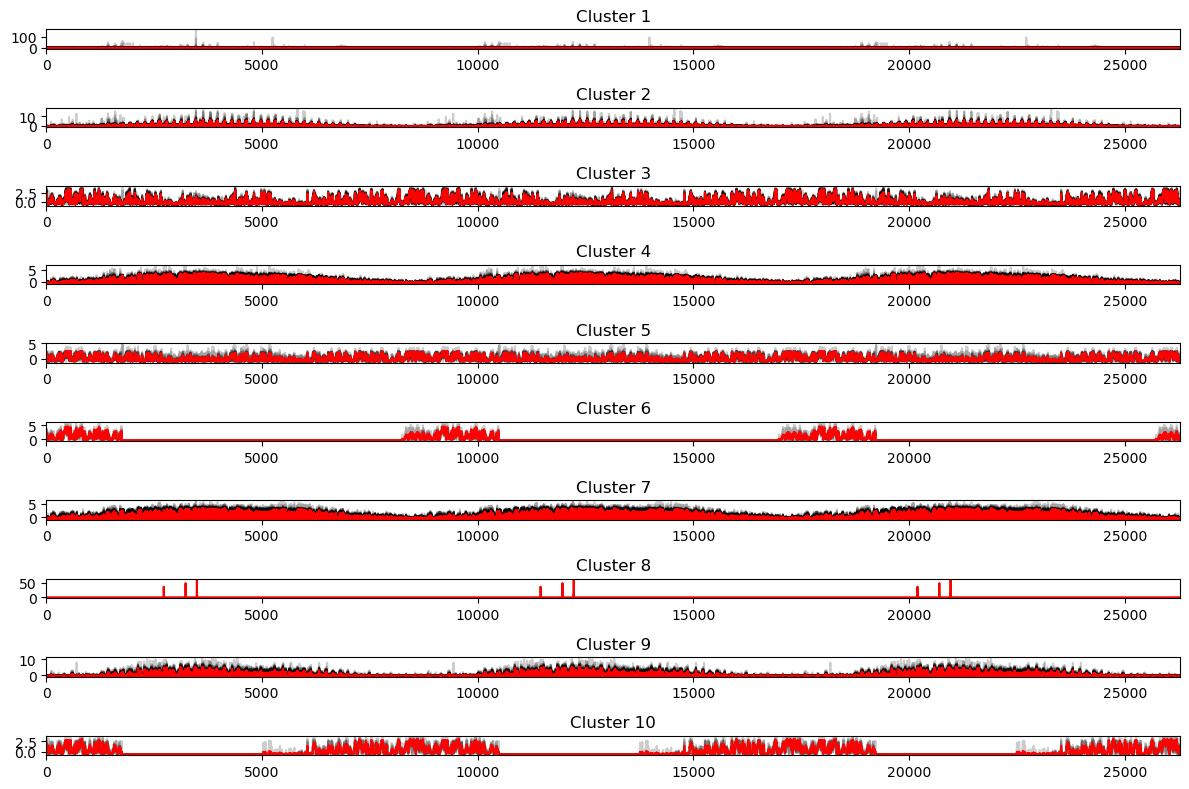

(TimeSeriesKMeans(n_clusters=10, verbose=True), TimeSeriesScalerMeanVariance())

In [14]:
#Fit all the models using 10 clusters
fit_model_and_visualize_clusters(consumption1y, 10)
fit_model_and_visualize_clusters(consumption3y, 10)
fit_model_and_visualize_clusters(production1y, 10)
fit_model_and_visualize_clusters(production3y, 10)

